### STOCK PREDICTIONS using LINEAR REGRESSION and LSTM

### STOCK Predictions using LINEAR REGRESSION MODEL with SQL LITE
Linear regression models the relationship between a dependent variable and one or more independent variables using a linear equation. For stock prediction, it might predict tomorrow's price based on a linear combination of today's prices, volumes, and other financial indicators. Used SQL lite to get data into dataframe to be used with other models.

Pros: Simplicity, Interpretability Cons: Assumes Linearity, Sensitive to Noise

NOTE :Linear regression can be adjusted for non-linear data (time series) by using "Differentiation" which can create features that capture the rate of change (first derivative) or the acceleration (second derivative) of a quantity could be useful in contexts like time-series forecasting.



###  STOCK PREDICTIONS using  LSTM

LSTM is a type of recurrent neural network (RNN) particularly good at learning from sequences (such as time series data). It can capture long-term dependencies and patterns in time series data, making it suitable for tasks like stock price predictions.

Pros: Sequence Memory, Flexibility
Cons: Complexity, Overfitting

In [1]:
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
from datetime import datetime
import sqlite3
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2]:
# Retrieve data
ticker = 'AAPL'
end_date = datetime.now().strftime('%Y-%m-%d')
data = yf.download(ticker, start='2020-01-01', end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [3]:
# Create connection to sqlite
conn = sqlite3.connect(':memory:')

# Store data in table
data.to_sql('stock_prices', conn, if_exists='replace', index=True)


1159

In [4]:
# Retrieve data from sqlite
query = "SELECT* FROM stock_prices"
df = pd.read_sql(query, conn)
df['Date'] = pd.to_datetime(df['Date'])


In [5]:
# Normalize and standardize the 'close' prices
df['Close'] = StandardScaler().fit_transform(df[['Close']])


In [6]:
# Train a linear regression model
X = df[['Open', 'High', 'Low', 'Volume']]
y = df['Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

df.head()

R-squared: 0.9992672198446886


,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,74.059998,75.150002,73.797501,-2.006077,72.960449,135480400
1,2020-01-03,74.287498,75.144997,74.125000,-2.026307,72.251152,146322800
2,2020-01-06,73.447502,74.989998,73.187500,-2.009888,72.826851,118387200
3,2020-01-07,74.959999,75.224998,74.370003,-2.019656,72.484344,108872000
4,2020-01-08,74.290001,76.110001,74.290001,-1.986402,73.650345,132079200


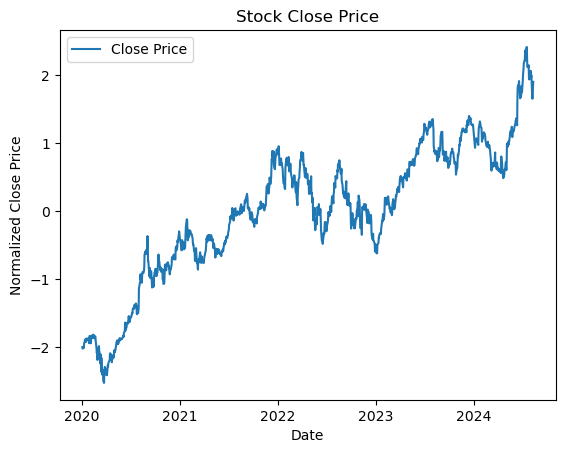

In [7]:
# Create a line chart of the 'Close' price
plt.plot(figsize=(10,6))
plt.plot(df['Date'], df['Close'], label='Close Price')
plt.xlabel('Date')
plt.ylabel('Normalized Close Price')
plt.title('Stock Close Price')
plt.legend()
plt.show()

###  NOTE: Avoid look ahead bias
 1. Model already has been fed H, L, O --> so it knows that the close is going to be in between H and L
 2. Hence the margin of error is low.
 3. You cannot possibly know the highest daily high and lowest daily low as long as the trading day is still active.
 3. It always good to use lag for predicting time series.

In [8]:
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
#from tensorflow.keras.callbacks import EarlyStopping


stock = yf.Ticker("AAPL")
stock = stock.history(period='2y')

In [9]:
stock.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-08-15 00:00:00-04:00,169.836777,171.688421,169.668448,171.490387,54091700,0.0,0.0
2022-08-16 00:00:00-04:00,171.084408,172.005290,169.975404,171.331955,56377100,0.0,0.0
2022-08-17 00:00:00-04:00,171.074521,174.421341,170.876486,172.837051,79542000,0.0,0.0
2022-08-18 00:00:00-04:00,172.044865,173.183573,171.421043,172.440933,62290100,0.0,0.0
2022-08-19 00:00:00-04:00,171.331968,172.035007,169.628846,169.836792,70346300,0.0,0.0


In [10]:
del stock['Dividends']
del stock['Stock Splits']

In [11]:
stock.head()

,Open,High,Low,Close,Volume
Date,,,,,
2022-08-15 00:00:00-04:00,169.836777,171.688421,169.668448,171.490387,54091700
2022-08-16 00:00:00-04:00,171.084408,172.005290,169.975404,171.331955,56377100
2022-08-17 00:00:00-04:00,171.074521,174.421341,170.876486,172.837051,79542000
2022-08-18 00:00:00-04:00,172.044865,173.183573,171.421043,172.440933,62290100
2022-08-19 00:00:00-04:00,171.331968,172.035007,169.628846,169.836792,70346300


<Axes: xlabel='Date'>

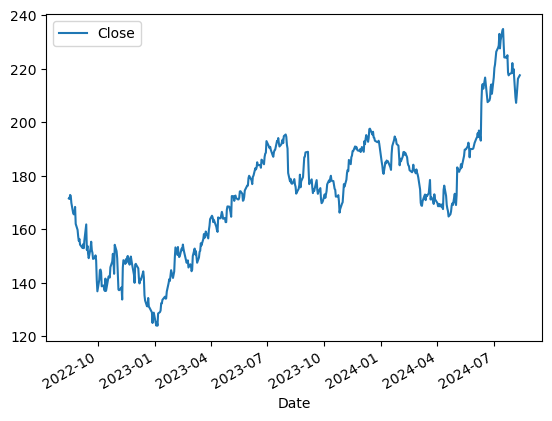

In [12]:
stock.plot.line(y="Close")

In [13]:
# Preparing data for forecasting future values. Shift(-1) shifts the index 
# and moves data the data up 1 period and removes the'NaN' value

stock["Next Days Close"] = stock['Close'].shift(-1)

In [14]:
# Compares Next Days Close with Close assigns a True/False value and converts 
# the boolean value to integer

stock['change'] = (stock['Next Days Close'] > stock['Close']).astype(int)



In [15]:
# Checking most current prices

stock.tail()  

,Open,High,Low,Close,Volume,Next Days Close,change
Date,,,,,,,
2024-08-06 00:00:00-04:00,205.300003,209.990005,201.070007,207.229996,69660500,209.820007,1
2024-08-07 00:00:00-04:00,206.899994,213.639999,206.389999,209.820007,63516400,213.309998,1
2024-08-08 00:00:00-04:00,213.110001,214.199997,208.830002,213.309998,47161100,216.240005,1
2024-08-09 00:00:00-04:00,212.100006,216.779999,211.970001,216.240005,42171700,217.529999,1
2024-08-12 00:00:00-04:00,216.000000,219.509903,215.600006,217.529999,37581880,NaN,0


In [16]:

# Set up look back window for new model using LSTM (LongShortTermMemory)
# begining of new model coding

import numpy as np
def look_back_period(X, y, look_back_window=20):
    X_lstm, y_lstm, = [],[]
    for i in range(len(X)- look_back_window):
        X_lstm.append(X[i:i+look_back_window])
        y_lstm.append(y[i+look_back_window])
    return np.array(X_lstm), np.array(y_lstm)

In [17]:
# Drop rows with NaN target values
stock = stock.dropna(subset=['Next Days Close', 'change'])

#dropped 'Next Days Close' because it is not needed in new model
stock = stock.drop(columns = "Next Days Close")

# Split our preprocessed data into our features and target arrays
y = stock['change']
X = stock.drop(columns=['change'])

# Preserve the index of the original DataFrame
original_index = X.index

In [18]:
# Normalize data:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [19]:
# Scaling data for LSTM lookback
# Creates dataset suitable for training a model that expects a sequence of data points

X_scaled, y = look_back_period(X_scaled, y)

In [20]:
# Shaping data 

X_scaled.shape, y.shape

((480, 20, 5), (480,))

In [21]:
#split data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42) #shuffle=False)



In [22]:
#import LSTM for layers and Sequential for new model
# LSTM is used for time series data 

from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential


In [23]:
X_train.shape


(384, 20, 5)

In [24]:

# using tanh activation, its better suited for stock market non-linearity
# dropout 0.2 helps with over fitting

model = Sequential()

model.add(LSTM(units=50, activation="tanh", return_sequences=True,input_shape=(X_train.shape[1],X_train.shape[2])))

model.add(LSTM(units=30,return_sequences=True, activation="tanh",))
model.add(Dropout(0.2))

model.add(LSTM(units=10, activation="tanh"))

model.add(Dense(1, activation="sigmoid"))

/Users/keycaughey/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
# Train the model

history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=10)


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4941 - loss: 0.6978 - val_accuracy: 0.4935 - val_loss: 0.6959
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5433 - loss: 0.6907 - val_accuracy: 0.4935 - val_loss: 0.6945
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5805 - loss: 0.6834 - val_accuracy: 0.4675 - val_loss: 0.6953
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5674 - loss: 0.6840 - val_accuracy: 0.4805 - val_loss: 0.7040
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5621 - loss: 0.6754 - val_accuracy: 0.4805 - val_loss: 0.7057
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4874 - loss: 0.6909 - val_accuracy: 0.4805 - val_loss: 0.7020
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5563 - loss: 0.6911 - val_accuracy: 0.4805 - val_loss: 0.7091
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5817 - loss: 0.6771 - val_accuracy: 0.5455 - val_loss

In [28]:
# Evaluate the model using the test data
model_loss, model_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {model_loss}, Test Accuracy: {model_accuracy}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4414 - loss: 0.7812 
Test Loss: 0.7749407887458801, Test Accuracy: 0.4375


In [29]:
# Make predictions
predictions = model.predict(X_test).round().flatten()


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


In [30]:
# Create a DataFrame for predictions with the index of X_test_df

predictions_df = pd.DataFrame(predictions, columns=['Predictions'])

In [31]:
precision_score(y_test,predictions)

0.5098039215686274

In [32]:
# checking to see if model is overtrained
# Looping through epochs to get data 

train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
num_epochs = 50
x_axis = [i for i in range(num_epochs)]


In [33]:
# Importing dependencies for overtrain analysis chart

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [34]:
# Creating function for overtrain analysis chart

def analysis_plot(x,train_data, val_data):
    plt.figure(figsize=(12,6))
    plt.plot(x,train_data,label = "train data")
    plt.plot(x,val_data, label = "val data")
    plt.legend()
    plt.plot();

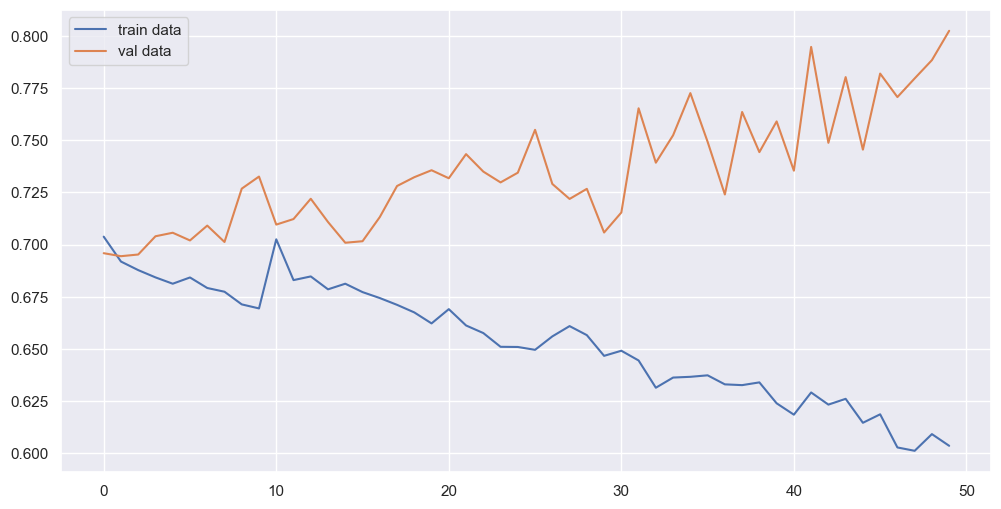

In [35]:
# Val data shows its overfitting the data 
# train data shows model is getting better at minimizing loss
# Adjust hyperparmeters

analysis_plot(x=x_axis,train_data = train_loss, val_data=val_loss)

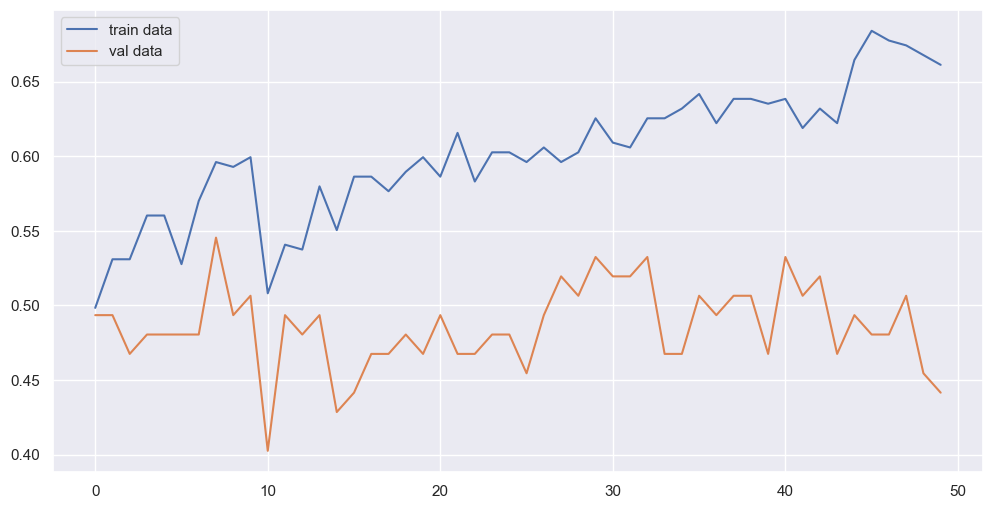

In [36]:
# Val data (accuracy), example: at 0.5 its correct only 1/2 the time
# Train data shows if its learning and improving on the data over time 
# if the line goes up
analysis_plot(x=x_axis,train_data = train_acc, val_data = val_acc)

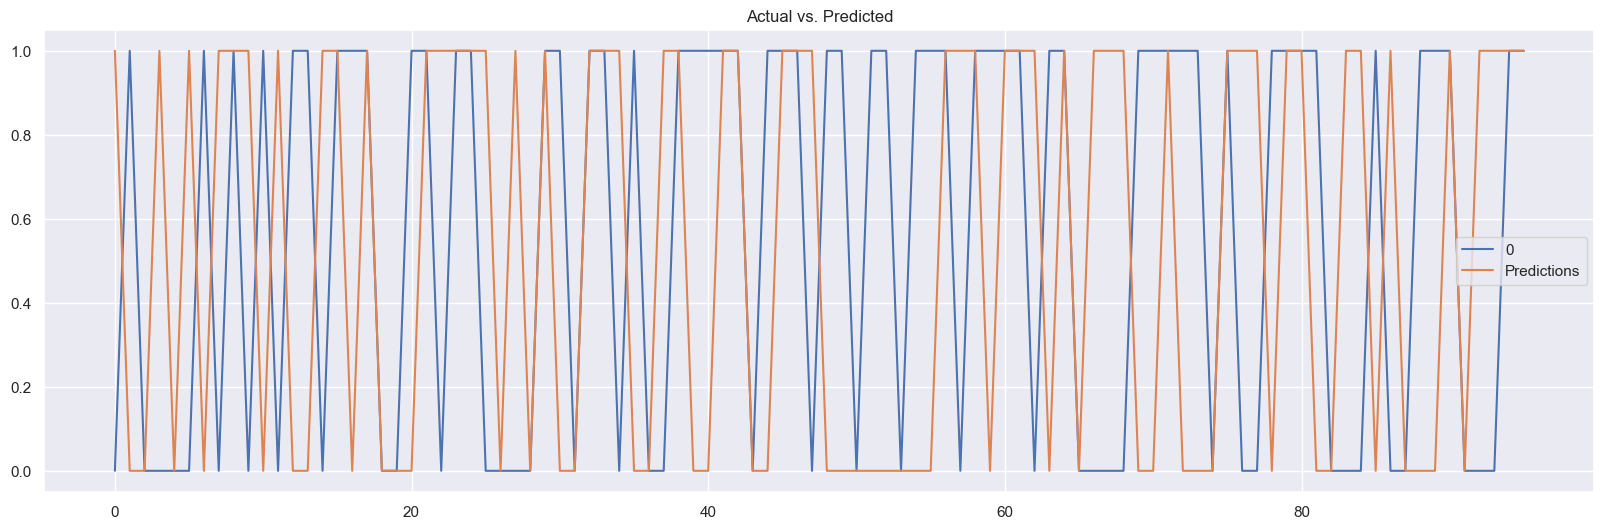

In [37]:
# Combine actual values and predictions
# Orange is predicted, Blue is actual
combined = pd.concat([pd.Series(y_test), predictions_df], axis=1)

# Plot the combined DataFrame
# plt.figure(figsize = (20,6))
combined.plot(title='Actual vs. Predicted', figsize=(20,6))
# plt.figure(figsize=(20,6))
plt.show()

In [38]:
combined.columns


Index([0, 'Predictions'], dtype='object')

In [39]:

# Prepare latest data for prediction
# Data is scaled 


look_back_window = 20  # Ensure this matches our function parameter
latest_data = X_scaled[-1].reshape(1, look_back_window, X_scaled.shape[2])
latest_data_df = pd.DataFrame(latest_data[0], columns=X.columns)

print(latest_data_df)

        Open      High       Low     Close    Volume
0   2.473750  2.558320  2.537503  2.539250 -0.507056
1   2.806500  2.760194  2.731925  2.709171 -0.118539
2   2.741359  2.717972  2.698419  2.727660 -0.904790
3   2.497078  2.506423  2.447567  2.466175 -0.332781
4   2.533610  2.461562  2.254909  2.259276  0.019412
5   2.293291  2.301471  2.299436  2.264999 -0.664938
6   2.389682  2.344572  2.291060  2.249592 -0.703434
7   2.273484  2.307628  2.272984  2.295813 -1.037500
8   2.257199  2.213509  2.028305  2.010997 -0.153144
9   2.034044  2.039783  1.917647  1.964776 -0.574153
10  2.023921  1.979969  1.978928  1.985466 -0.970983
11  1.947336  1.971612  1.967465  1.997791 -1.185391
12  2.045489  2.016913  1.983777  2.022443 -0.969260
13  2.144521  2.170407  2.182608  2.166832 -0.629073
14  2.273484  2.199434  2.023455  2.003074 -0.123821
15  2.043728  2.248694  2.053875  2.069105  1.621909
16  1.160795  1.716522  1.096758  1.602923  2.188583
17  1.434126  1.562148  1.320276  1.513119  0.

In [40]:

# Prepare latest data for prediction
latest_data = stock.drop(columns=['change']).iloc[-look_back_window:]  # Get the last look_back_window rows
latest_data_scaled = scaler.transform(latest_data)  # Scale the data
latest_data_reshaped = latest_data_scaled.reshape(1, look_back_window, latest_data_scaled.shape[1])  # Reshape to (1, look_back_window, num_features)


In [41]:

# Make prediction for the next day
next_day_prediction = model.predict(latest_data_reshaped).round().flatten()[0]

# Interpret the prediction
if next_day_prediction == 1:
    print("The model predicts that the stock price will increase the next day.")
else:
    print("The model predicts that the stock price will decrease the next day.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
The model predicts that the stock price will increase the next day.


In [42]:
precision = precision_score(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
r_squared = r2_score(y_test, predictions)


print(f'Precision: {precision}')
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'R-squared: {r_squared}')


Precision: 0.5098039215686274
Accuracy: 0.4375
Recall: 0.4727272727272727
F1 Score: 0.49056603773584906
R-squared: -1.298891352549889


Precision is the ratio of true positive predictions to the total number of positive predictions (both true and false positives).

Accuracy is the ratio of correct predictions (both true positives and true negatives) to the total number of predictions.Low accuracy suggests that the model isn't very reliable overall.

Recall (or sensitivity) is the ratio of true positive predictions to the total number of actual positives (true positives and false negatives).Low recall suggests that the model misses a significant number of actual stock price increases (high false negative rate).

F1 Score is the harmonic mean of precision and recall, providing a single metric that balances the two. It ranges from 0 to 1, where 1 indicates perfect precision and recall. However, given that both precision and recall are not very high, the F1 score reflects the model's overall mediocre performance.

R-squared (R²) measures the proportion of variance in the dependent variable (stock price change) that is predictable from the independent variables (features in your model). Negative R-squared values suggest that the model is not fitting the data well and may even be introducing more error than a simple average prediction.




[*********************100%%**********************]  11 of 11 completed


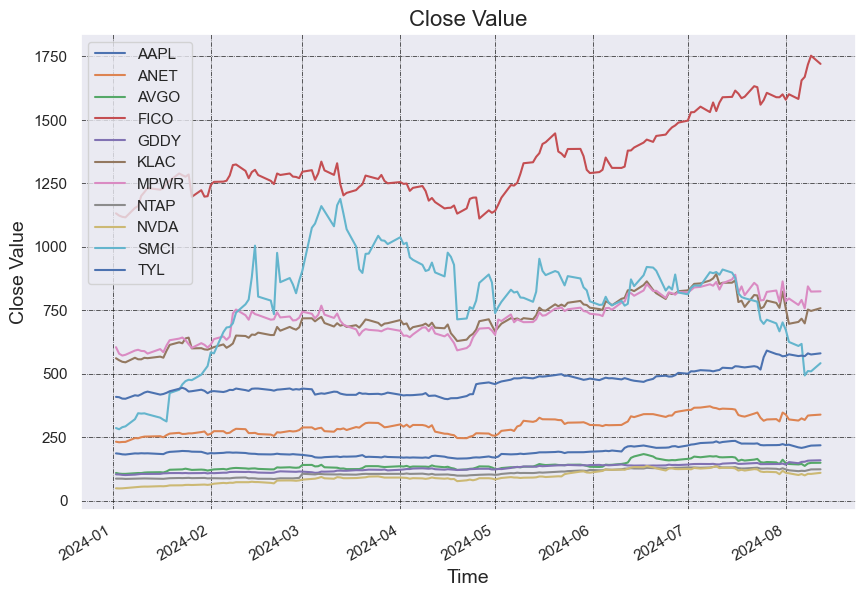

In [43]:
# Original graph 
# Define the ticker list
import pandas as pd
tickers_list = ['SMCI', 'NVDA', 'ANET', 'NTAP', 'AVGO', 'KLAC', 'FICO', 'GDDY', 'MPWR', 'TYL','AAPL']

# Fetch the data
import yfinance as yf
data = yf.download(tickers_list,'2024-1-1')['Close']

# Plot all the close prices
((data.plot(figsize=(10, 7))))
plt.legend()
plt.title("Close Value", fontsize=16)

# Define the labels
plt.ylabel('Close Value', fontsize=14)
plt.xlabel('Time', fontsize=14)

# Plot the grid lines
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()